In [29]:
import torch
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dynamic_tasker.access import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.orbits import *
from dynamic_tasker.cameras import *
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from gymnasium.wrappers import RecordEpisodeStatistics 
import scipy.stats as st
import datetime
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
class LookaheadEnv(gym.Env):

    def __init__(self, orbit, requests, t_start, t_end, agility, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False):
        self.orbit = orbit
        self.requests = requests
        self.t_start = t_start
        self.t_end = t_end
        self.agility = agility
        self.field_of_regard = field_of_regard
        self.width = 800
        self.height = 800
        self.K = get_intrinsics_from_fov(45, self.width, self.height)
        self.eval_analytic = eval_analytic
        self.orbit_reset_count = 0
        # Obtain the omniscient schedule
        self.accesses = get_accesses(requests, orbit, 500, 45, t_start, t_end)
        # Assign the states
        for i in range(len(self.accesses)):
            self.accesses[i].state = {"observed": False, "cloudy": np.random.rand() < 0.66}

        # self.optimal_schedule = milp_schedule(self.orbit, self.requests, t_start, t_end)
        self.schedule = milp_schedule(self.accesses, self.requests, self.agility)
        # Calculate how many tasks in the schedule are not cloudy
        self.base_advantage = np.sum([not a.state["cloudy"] for a in self.schedule])
        self.current_idx = 0
        
        # Try first discretizing in just time and angle...
        self.crosstrack_discretization = crosstrack_discretization
        self.alongtrack_discretization = alongtrack_discretization

        # Figure out the number of states
        self.crosstrack_states = int(np.floor(2 * self.field_of_regard) / (self.crosstrack_discretization))
        # First figure out the horizon angle
        self.horizon_angle = horizon_angle(self.orbit)
        self.horizon_time = horizon_time(self.orbit)
        self.alongtrack_states = int(np.floor(self.horizon_time/ (self.alongtrack_discretization)))


        # total_observational_states = crosstrack_states * alongtrack_states

        # Action space - 3d vector, 
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = spaces.Box(low=0.0, high=np.inf, shape=(2, self.alongtrack_states, self.crosstrack_states))


    def step(self, action):
        # Current time...
        time = self.schedule[self.current_idx].time
        orbit_new = propagate_orbit(self.orbit, time)
        r , v = kepler2eci(orbit_new)
        pos_ecef = eci2ecef(r, time)
        
        # Convert to ECI points
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(self.accesses)]
        accesses_filtered = filter_accesses_horizon(orbit_new, time, accesses_converted, pos_ecef)
        points = np.array([r for r, _, _, _, _ in accesses_filtered])

        # Get pitch and roll from action
        pitch_deg = action[0] * 90

        # roll_deg = np.arcsin(action[2])
        # For now roll_deg = 0
        roll_deg = 0

        # (Optional) Return equivalent analytic DT pairing
        # Calculate analytic heuristic...
        if(self.eval_analytic):
            _, _, utility_analytic, _, _, _, _ = actual_advantage(pitch_deg, roll_deg, orbit_new, self.K, time, accesses_filtered, points, self.schedule)
        # If the first action is 0, don't do anything
        if pitch_deg <= 22.5 or len(accesses_filtered) == 0:
                
            self.current_idx = self.current_idx + 1
            return self._get_obs(accesses_filtered, self.schedule,time), 0, False, True, {"utility_analytic": None if not self.eval_analytic else utility_analytic}


        # Now project them into the camera frame
        projected_accesses, in_box = project_in_box(pitch_deg, roll_deg, orbit_new, time, accesses_filtered, points, self.width, self.height, self.K)
        # Mark the ones in box as observed
        for i in in_box:
            accesses_filtered[i][-2].state["observed"] = True

        # Calculate the total advantage
        times = [a[-2].time for a in accesses_filtered]
        max_time = np.max(times)
        min_time = np.min(times)

        # Get the slice of the schedule that is in the time range
        schedule_slice = [a for a in self.schedule if a.time >= min_time and a.time <= max_time]
        original_schedule_advantage = np.sum([not a.state["cloudy"] for a in schedule_slice])
        access_slice = [a for a in self.accesses if a.time >= min_time and a.time <= max_time and not (a.state["observed"] and a.state["cloudy"])]

        new_schedule = milp_schedule(access_slice, self.requests, self.agility)
        new_advantage = np.sum([not a.state["cloudy"] for a in new_schedule])

        # 22.5 deg boresight        
        t_maneuver = (self.agility(pitch_deg - 22.5) * 2) - self.agility(0)
        missed_opportunities = len([s for s in schedule_slice if not s.state["cloudy"] and self.agility(s.angle) > t_maneuver])
        reward = new_advantage - missed_opportunities - original_schedule_advantage - 0.001 * (t_maneuver)

        # Move to the next schedule block
        self.current_idx = self.current_idx + 1
        
        return self._get_obs(accesses_filtered, self.schedule, time), reward, False, True, {"utility_analytic": None if not self.eval_analytic else utility_analytic}
    
    def reset(self, seed=None, options=None):
        # Only actually reset when current_idx is at the end
        if self.current_idx >= (len(self.schedule) - 1):
            self.orbit_reset_count = self.orbit_reset_count + 1

            if(self.orbit_reset_count > 10):
                self.requests = generate_requests(10000)
                self.accesses = get_accesses(self.requests, self.orbit, 500, 45, self.t_start, self.t_end)
                self.orbit_reset_count = 0

            self.current_idx = 0
            for a in self.accesses:
                a.state = {
                    "observed": False,
                    "cloudy": np.random.rand() < 0.66
                }
                
            self.schedule = milp_schedule(self.accesses, self.requests, self.agility)
            
        r , v = kepler2eci(self.orbit)
        pos_ecef = eci2ecef(r, self.t_start)    
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(self.accesses)]
        accesses_filtered = filter_accesses_horizon(self.orbit, self.t_start, accesses_converted, pos_ecef)

        return self._get_obs(accesses_filtered, self.schedule, self.t_start), {}

    def _get_obs(self, accesses, schedule, time):
        # Source data
        times = [(a[2] - time).total_seconds() for a in accesses if not a[-2].state["observed"]]
        angles = [a[1] for a in accesses if not a[-2].state["observed"]]

        schedule_times = [(a.time - time).total_seconds() for a in schedule]
        schedule_angles = [a.angle for a in schedule]

        # Convert to 2D histogram
        hist_accesses = np.histogram2d(times, angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]])
        hist_schedule = np.histogram2d(schedule_times, schedule_angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]])

        return np.stack([hist_accesses[0].astype(np.float32), hist_schedule[0].astype(np.float32)])

    def _get_reward(self):
        pass

    def close(self):    
        pass

In [10]:
# Generate randomly spaced requests

def generate_requests(N):
    """
    Generate N Request objects with lat/long
    sampled uniformly over Earth's surface, using numpy.
    """
    # 1) sample z = sin(lat) uniformly in [-1,1]
    z = np.random.uniform(-1.0, 1.0, size=N)
    # 2) sample longitude angle θ uniformly in [0, 2π)
    theta = np.random.uniform(0.0, 2*np.pi, size=N)

    # convert to lat, lon in degrees
    lat = np.degrees(np.arcsin(z))
    lon = np.degrees(theta)
    # shift to [–180, +180)
    lon = np.where(lon > 180.0, lon - 360.0, lon)

    # build Request instances
    return [
        Request(i, float(lat[i]), float(lon[i]), f"request_{i}")
        for i in range(N)
    ]

# requests = generate_requests(10)
# print(requests)

In [11]:
# Train with PPO
t0 = datetime.datetime(2024, 1, 1)
t_end = datetime.datetime(2024, 1, 1, 18, 0, 0)

h = 400
field_of_regard = 45
crosstrack_discretization = 7.5 # deg
alongtrack_discretization = 10 # seconds

t_s = 10
t_dotsq = 4
def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
requests = generate_requests(10000)

# env.reset()
# env.step(np.array([1, 0, 0]))
# env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization)

# check_env(env)

In [12]:
# Some helpers for the analytic one
width = 800
height = 600

def analytic_chain_probability(L, lam, M, c):
    if L < (M-1)*c:
        return 0.0
    x = L - (M-1)*c
    # Note: scipy's gamma.cdf(x, a, scale) uses 'a' as the shape and scale=1/rate.
    return st.gamma.cdf(x, a=M-1, scale=1/lam)

def expected_advantage(N, t_total, t_gap, A_min, A_max):
   all_adv = np.arange(A_min, A_max+1)

   probabilities = np.array([analytic_chain_probability(t_total, N/t_total * 1/3, adv + 2, t_gap) for adv in all_adv])
   probabilities = [probabilities[i] - probabilities[i+1] for i in range(len(probabilities)-1)]
   probabilities = np.append(probabilities, probabilities[-1])
   
   return np.sum(probabilities * all_adv)

def actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule):
    accesses_inbox, in_box_idx = project_in_box(pitch_deg, roll_deg, orbit, time, accesses_filtered, points, width, height, K)
    N = len([a for a in accesses_inbox if a[-2].state["observed"] == False]) * 0.34
    adv = 0
    if(N > 0):
        t_total = np.max([a[2] for a in accesses_inbox]) - np.min([a[2] for a in accesses_inbox])
        t_gap = agility_bangbang(30)

        if(t_total.total_seconds() > 0):
            adv = expected_advantage(N, t_total.total_seconds(), t_gap, 2, 40)

    # Now calculate cost...
    # Check how many tasks in the schedul we miss
    schedule_filtered = [s for s in schedule if s.time > time and s.time <= time + datetime.timedelta(hours=1)]
    # Total lookahead maneuver time
    # No setting time for lookahead
    # Assume 35 deg boresight angle
    t_maneuver = 2 * (agility_bangbang(pitch_deg - 35)) - agility_bangbang(0)

    schedule_missed = [s for s in schedule_filtered if time + datetime.timedelta(seconds=t_maneuver) > s.time]

    cost = len(schedule_missed) * 0.34
    utility = adv - cost
    missed = len(schedule_missed)
    return accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver

def evaluate_lookahead_chain(time, orbit, schedule, accesses, K):
    orbit_new = propagate_orbit(orbit, time)
    r , v = kepler2eci(orbit_new)
    pos_ecef = eci2ecef(r, time)
    v_ecef = eci2ecef(v, time)

    accesses_filtered = filter_accesses_horizon(orbit, time, accesses, pos_ecef)
    min_time = agility_bangbang(30)
    accesses_filtered = [a for a in accesses_filtered if a[-2].time > time + datetime.timedelta(seconds=min_time)]
    # Let's do a test to figure out what the heuristic will do best at...
    points = np.array([r for r, _, _, _, _ in accesses_filtered])
    idxs = np.array([i for _, _, _, _, i in accesses_filtered])

    roll_deg = 0
    pitch_degs = np.linspace(0, 70)

    expected_utilities = []
    expected_advantages = []
    expected_costs = []
    for pitch_deg in pitch_degs:
        _, _, utility, adv, cost, _, _ = actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)
        
        expected_utilities.append(utility)
        expected_advantages.append(adv)
        expected_costs.append(cost)

    # Find the maximum advantage
    max_adv = np.max(expected_utilities)
    max_idx = np.argmax(expected_utilities)
    # Find the pitch angle that gives the maximum advantage
    best_pitch_deg = pitch_degs[max_idx]

    # Recalculate in box
    accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver = actual_advantage(best_pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)

    mapped_in_box_idx = [idxs[i] for i in in_box_idx]
    # Recalculate utility

    return ((best_pitch_deg, roll_deg), mapped_in_box_idx, expected_utilities, expected_advantages, expected_costs, utility, adv, cost, missed, t_maneuver)

In [40]:
# Now train with PPO
# env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False)
# eval_env = env
# env = RecordEpisodeStatistics(env)
# env = DummyVecEnv([lambda: env])
# env = AsyncVectorEnv(env)
def make_env(rank, seed=0):
    def _init():
        env = LookaheadEnv(
            orbit, requests, t0, t_end,
            agility_bangbang, field_of_regard,
            crosstrack_discretization, alongtrack_discretization,
            eval_analytic=False,
        )
        env = RecordEpisodeStatistics(env)
        env.reset(seed=seed + rank)       # different seed per worker
        return env
    return _init

N_ENVS = 12                                # ≤ number of CPU cores
train_env = SubprocVecEnv([make_env(i) for i in range(N_ENVS)])
# env = VecNormalize(env, norm_obs=True, norm_reward=True)


/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: Runt

In [ ]:
# model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./test_with_schedule")

# Define a larger policy network with 5 layers
policy_kwargs = {
    "net_arch": {
        "pi": [256, 256, 256, 256, 256],  # Policy network: 5 layers of 256 units
        "qf": [256, 256, 256, 256, 256]   # Q-function network: 5 layers of 256 units
    }
}

model = SAC("MlpPolicy", train_env, verbose=0, tensorboard_log="./test_with_schedule", policy_kwargs=policy_kwargs, gamma=1.0, batch_size=1024)
# model = PPO("MlpPolicy", train_env, verbose=0, tensorboard_log="./test_with_schedule", policy_kwargs=policy_kwargs, gamma=1.0)
model.learn(total_timesteps=500000)

In [ ]:
model.save("test_with_schedule_sac_200k")

In [ ]:
# Eval environment

# eval_env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=True)

True


In [36]:
N = 500

eval_env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=True)
analytic_rl_pairs = []
state = eval_env.reset()[0]
for i in tqdm(range(N)):
    action, _ = model.predict(state)
    print(action[0] * 90)
    # pitch_deg = np.rad2deg(np.arcsin(action[1]))
    # roll_deg = np.rad2deg(np.arcsin(action[1]))
    # print(roll_deg)
    state, reward, done, truncated, info = eval_env.step(action)
    eval_env.reset()
    analytic_rl_pairs.append((info["utility_analytic"], reward))

    if done:
        state = eval_env.reset()

print(analytic_rl_pairs)

  1%|          | 5/500 [00:00<00:12, 40.81it/s]

73.90709
79.09366
80.325554
82.76476
74.17473
57.77459
52.780937
72.093796
79.1599


  3%|▎         | 15/500 [00:00<00:11, 41.16it/s]

75.533775
66.82771
76.54581
61.618603
79.679634
50.17115
70.03984
61.6068
62.651897


  4%|▍         | 20/500 [00:00<00:11, 40.19it/s]

71.21295
60.895702
68.833176
76.01232
80.71373
68.93485


  6%|▌         | 30/500 [00:00<00:12, 37.33it/s]

61.51361
60.175457
57.80167
74.59487
67.91718
57.27912
61.924255
66.894775
77.74807
77.65414


  8%|▊         | 40/500 [00:01<00:11, 39.79it/s]

72.49429
62.09992
74.87614
76.321144
77.86944
42.79281
78.52468
65.69603
66.1902


 10%|█         | 50/500 [00:01<00:10, 41.86it/s]

66.980835
72.462814
74.362724
50.427483
67.533516
66.77554
78.149025
77.857834
81.37307


 12%|█▏        | 60/500 [00:01<00:10, 41.16it/s]

71.48244
54.943516
74.90001
72.63231
77.81995
68.06844
66.01733
62.85763
77.61347


 13%|█▎        | 65/500 [00:01<00:10, 41.56it/s]

79.31076
72.58598
65.13887
57.62518
75.76482
54.21019
76.19431
72.49518
68.60674


 15%|█▌        | 75/500 [00:01<00:10, 41.21it/s]

73.00806
76.312965
75.09312
67.624855
73.64258
73.67728
72.57827
71.44798
76.53621


 17%|█▋        | 85/500 [00:02<00:10, 40.76it/s]

83.69026
80.27171
73.88269
69.625725
44.37764
40.438293
34.452847
75.6804
67.81406


 19%|█▉        | 95/500 [00:02<00:09, 41.34it/s]

58.179237
69.256035
45.959126
69.11905
73.52772
59.748234
75.91383
62.85701
75.07705


 21%|██        | 105/500 [00:02<00:09, 40.45it/s]

63.230556
61.55494
57.549026
66.36944
61.64769
83.05827
75.43039
72.861015
71.894165


 22%|██▏       | 110/500 [00:02<00:09, 41.15it/s]

76.84265
77.74794
63.37957
72.095566
69.16689
43.78968
62.782875
70.84654
39.763084


 24%|██▍       | 120/500 [00:02<00:09, 42.01it/s]

65.56014
74.9942
29.72968
45.179527
75.38539
64.64303
70.898705
67.29321
73.30392


 26%|██▌       | 130/500 [00:03<00:08, 41.89it/s]

46.48589
70.88205
66.88994
71.39418
84.6514
56.79625
80.36808
50.947285
78.57461


 28%|██▊       | 140/500 [00:03<00:08, 42.30it/s]

73.08927
63.93882
79.00481
55.87241
72.92757
37.464214
71.575775
75.77854
61.25219


 30%|███       | 150/500 [00:03<00:08, 41.59it/s]

65.876686
37.38197
75.833664
66.57733
78.81317
78.588684
64.8232
56.594524
77.61576


 31%|███       | 155/500 [00:03<00:08, 42.17it/s]

79.23282
78.3555
69.305984
58.831764
67.37076
79.53117
63.188328
68.803894
56.91922


 33%|███▎      | 165/500 [00:04<00:08, 41.81it/s]

56.474384
68.953896
80.31458
67.07225
59.29008
70.11461
52.98412
82.99833


 35%|███▌      | 175/500 [00:04<00:08, 37.84it/s]

75.07278
53.92901
65.832695
67.135994
72.32357
67.26549
66.38283
61.350758
62.20518


 37%|███▋      | 185/500 [00:04<00:07, 39.80it/s]

59.484573
84.97779
74.08343
63.636063
34.35635
78.82947
54.371628
50.85198
62.090523


 38%|███▊      | 190/500 [00:04<00:07, 40.00it/s]

51.016193
61.770073
79.05383
81.04891
63.564598
79.603264
64.58757
62.619743
84.36039


 40%|████      | 200/500 [00:04<00:07, 42.31it/s]

73.90505
65.45549
63.16117
51.82251
72.14298
73.34779
75.70866
60.239895
73.21847
73.6135


 42%|████▏     | 210/500 [00:05<00:06, 43.35it/s]

82.41206
81.56458
34.140926
60.45928
79.04991
74.40645
61.9748
70.05503
49.768623
77.57079


 44%|████▍     | 220/500 [00:05<00:06, 42.68it/s]

74.8413
63.447975
76.5623
60.779587
65.890396
77.03169
76.48001
73.46043
67.29833


 46%|████▌     | 230/500 [00:05<00:06, 43.17it/s]

64.545494
62.20545
67.257195
71.11695
45.7978
77.06527
67.29145
65.43594
70.29076
73.626465


 48%|████▊     | 240/500 [00:05<00:06, 42.07it/s]

57.043236
58.04122
54.35177
43.070034
75.86849
73.47459
69.59298
83.79313
70.1134


 50%|█████     | 250/500 [00:06<00:05, 42.71it/s]

79.30391
80.8768
75.31686
71.05616
72.56734
77.65346
66.05654
71.77569
63.607697
72.79578


 52%|█████▏    | 260/500 [00:06<00:05, 43.52it/s]

80.0972
79.80641
54.12348
76.72688
58.068947
75.893814
71.71742
69.95138
70.371605
71.81825


 54%|█████▍    | 270/500 [00:06<00:05, 43.50it/s]

79.17018
55.388527
73.39084
70.54152
65.88986
62.44202
61.46503
78.68574
65.314514


 56%|█████▌    | 280/500 [00:06<00:04, 44.05it/s]

74.28817
53.686646
76.695724
82.53238
65.949295
78.93202
79.40356
73.29613
76.99019
72.88158


 57%|█████▋    | 285/500 [00:06<00:04, 44.20it/s]

58.61264
62.988857
61.007572
72.72056
79.16656
74.70684
60.226387


 59%|█████▉    | 295/500 [00:07<00:05, 39.83it/s]

75.86875
66.76167
79.85791
39.37443
64.69754
69.34708
83.40738
59.639584
75.46665


 61%|██████    | 305/500 [00:07<00:04, 40.91it/s]

60.484684
79.29878
68.06575
54.916653
70.049515
59.364258
70.70446
57.28513
71.93869


 63%|██████▎   | 315/500 [00:07<00:04, 41.87it/s]

66.58888
56.72324
79.09319
72.91698
62.435303
76.53881
76.35537
64.90257
73.87072


 64%|██████▍   | 320/500 [00:07<00:04, 42.49it/s]

54.73437
77.967415
77.34135
68.83013
50.18631
72.80601
69.12049
55.851143
71.38005


 66%|██████▌   | 330/500 [00:07<00:04, 40.97it/s]

70.53182
80.82588
82.88291
64.13271
75.93119
60.612194
70.139595
67.14131
69.157906


 68%|██████▊   | 340/500 [00:08<00:04, 39.96it/s]

72.095764
78.90799
69.97145
73.42227
79.20458
71.40274
76.72873
76.420105
50.069267


 70%|███████   | 350/500 [00:08<00:03, 41.04it/s]

58.69512
68.00524
58.274746
79.541405
51.67842
81.71642
59.696766
64.87632
73.61621


 72%|███████▏  | 360/500 [00:08<00:03, 43.01it/s]

82.77243
73.67854
59.28068
77.33438
69.0374
64.24742
77.918175
75.398
73.96125
82.515144


 74%|███████▍  | 370/500 [00:08<00:03, 41.30it/s]

62.430946
41.942818
51.813797
77.12658
69.86472
62.140625
62.389835
75.90499
79.9194


 75%|███████▌  | 375/500 [00:09<00:03, 40.94it/s]

68.30103
76.50113
77.12883
57.812355
40.430386
53.814274
61.25113
59.68016
65.853294


 77%|███████▋  | 385/500 [00:09<00:02, 41.02it/s]

73.25895
79.32701
60.098175
76.27918
67.26759
55.59408
56.174843
71.51363
65.819496


 79%|███████▉  | 395/500 [00:09<00:02, 39.36it/s]

74.992485
67.69773
61.653416
82.92953
73.257965
64.75234
76.10311
76.13341


 81%|████████  | 404/500 [00:09<00:02, 37.86it/s]

54.99318
63.294907
71.35285
69.967804
65.00665
73.3991
71.502754
72.34948


 82%|████████▏ | 412/500 [00:10<00:02, 37.69it/s]

70.73724
81.98721
79.74036
70.63473
45.6945
67.03017
47.364227
69.88826


 84%|████████▍ | 421/500 [00:10<00:01, 39.53it/s]

73.85984
66.38724
78.08678
64.31824
65.51626
71.00395
73.71248
78.238976
73.98944


 86%|████████▌ | 431/500 [00:10<00:01, 41.78it/s]

73.50409
74.044205
71.32897
71.20808
77.65909
80.80872
80.15474
68.51671
59.448524
44.949608


 87%|████████▋ | 436/500 [00:10<00:01, 35.57it/s]

59.933273
66.075745
74.72594
66.17726
69.99043
75.14485


 89%|████████▉ | 446/500 [00:10<00:01, 37.68it/s]

78.45952
72.84594
60.417328
70.79032
56.266758
59.246704
68.66176
72.69336
79.563675


 91%|█████████ | 455/500 [00:11<00:01, 38.92it/s]

77.41247
70.02942
78.53038
43.793938
80.30783
75.378174
33.078312
51.41565
69.7906


 93%|█████████▎| 463/500 [00:11<00:00, 38.78it/s]

55.38549
56.47683
66.076
81.59765
70.169975
73.31468
69.781494
70.371185
80.58199


 94%|█████████▍| 472/500 [00:11<00:00, 39.47it/s]

60.113743
74.7417
73.77708
70.9084
81.574455
80.714
80.941345
65.1167
60.490402


 96%|█████████▌| 480/500 [00:11<00:00, 39.30it/s]

70.94812
70.78154
68.52057
50.700104
70.54038
80.033585
75.711655
69.32692
56.623043


 98%|█████████▊| 489/500 [00:12<00:00, 39.15it/s]

76.58756
72.76445
66.67005
34.708664
60.813812
49.75489
62.870678
73.26619
73.36691


100%|█████████▉| 498/500 [00:12<00:00, 38.14it/s]

53.97963
74.84505
83.238365
62.442192
63.686737
70.78236
66.0121
73.92112


100%|██████████| 500/500 [00:12<00:00, 40.60it/s]

[(np.float64(-0.44455622903690817), np.float64(0.9326410064697266)), (-0.34, np.float64(0.9298169937133789)), (np.float64(-0.6799636073234443), np.float64(0.9291655120849609)), (np.float64(-0.6772355058967514), np.float64(0.9278956909179688)), (np.float64(-0.6799479877587904), np.float64(2.932491889953613)), (-0.34, np.float64(1.9424860687255858)), (-0.34, np.float64(1.9459775085449218)), (np.float64(-0.32346965522043525), np.float64(-0.06633828735351563)), (np.float64(-0.6791676804632231), np.float64(-0.07021821594238281)), (np.float64(-0.679620074181243), np.float64(-0.06825942993164062)), (-0.34, np.float64(0.9367367553710937)), (np.float64(-0.3394209239424407), np.float64(-0.06881268310546876)), (np.float64(-0.33511389434010147), np.float64(-0.060035888671875)), (-0.34, np.float64(-1.0704937744140626)), (-0.34, np.float64(-1.0520826988220215)), (np.float64(-0.338809371416103), np.float64(-0.06515931701660156)), (np.float64(-0.3394734398796973), np.float64(-1.0600283432006836)), (0.

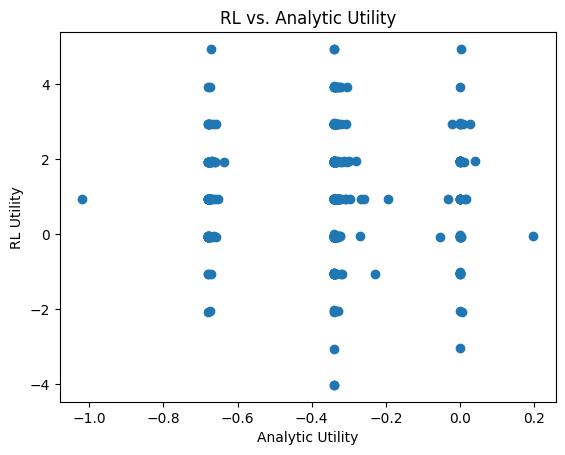

In [35]:
analytic_utility = [x[0] for x in analytic_rl_pairs]
rl_utility = [x[1] for x in analytic_rl_pairs]

plt.scatter(analytic_utility, rl_utility)
plt.xlabel("Analytic Utility")
plt.ylabel("RL Utility")
plt.title("RL vs. Analytic Utility")
plt.show()